## Load Data

This dataset [Electricity Load Diagrams 20112014 Data Set](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#) is from UCI Machine Learning Repository.

### Data Set Information:

Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [ ]:
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
df = pd.read_csv("data/LD2011_2014.txt", sep = ';', index_col = 0, dtype=str)

In [ ]:
print(df.shape)

(140256, 370)


# Data processing & Pre-Modeling

## Data Cleaning

- Melt the wide data matrix to long data matrix
- Convert index to timestamps, entries to numeric

In [ ]:
def preprocessing(dataframe):
    # convert index (timestamp) to a new column
    dataframe = dataframe.reset_index().rename(columns={"index": "timestamp"})

    # unpivot the data
    dataframe = dataframe.melt(id_vars=['timestamp'], var_name='user', value_name='usage_per_15min')
    # fix the timestamp
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], format = '%Y-%m-%d %H:%M:%S')
    # fix electricity usage
    dataframe['usage_per_15min'] = dataframe['usage_per_15min'].apply(lambda x: str(x).replace(',', '.')).astype(float)

    return dataframe

df = preprocessing(df)

In [ ]:
def aggregate_date(dataframe): #this rolls up electricity usage to a single day -- into sum and sd vals
    dataframe['date'] = pd.to_datetime((dataframe.timestamp - np.timedelta64(1, 'm')).dt.date)
    dataframe_day = dataframe.groupby(['user', 'date']).sum().reset_index()
    dataframe_day = dataframe_day.rename(columns={'usage_per_15min': 'sum_per_day'})
    dataframe_day['std_per_day'] = dataframe.groupby(['user', 'date']).std().reset_index().usage_per_15min

    return dataframe_day

df_day = aggregate_date(df)
df_day.head()

,user,date,sum_per_day,std_per_day
0,MT_001,2011-01-01,0.0,0.0
1,MT_001,2011-01-02,0.0,0.0
2,MT_001,2011-01-03,0.0,0.0
3,MT_001,2011-01-04,0.0,0.0
4,MT_001,2011-01-05,0.0,0.0


user
MT_012    605
MT_015    629
MT_030    493
MT_039    640
MT_041    620
MT_092    395
MT_106    743
MT_107    743
MT_108    743
MT_109    778
MT_110    743
MT_111    743
MT_112    772
MT_113    743
MT_115    743
MT_116    778
MT_117    743
MT_120    743
MT_121    743
MT_122    743
MT_133    801
MT_160    764
MT_165    612
MT_170    423
MT_178    929
MT_179    719
MT_181    794
MT_185    536
MT_186    633
MT_223    829
MT_224    539
MT_289    697
MT_305    707
MT_322    606
MT_337    747
MT_347    622
Name: sum_per_day, dtype: int64


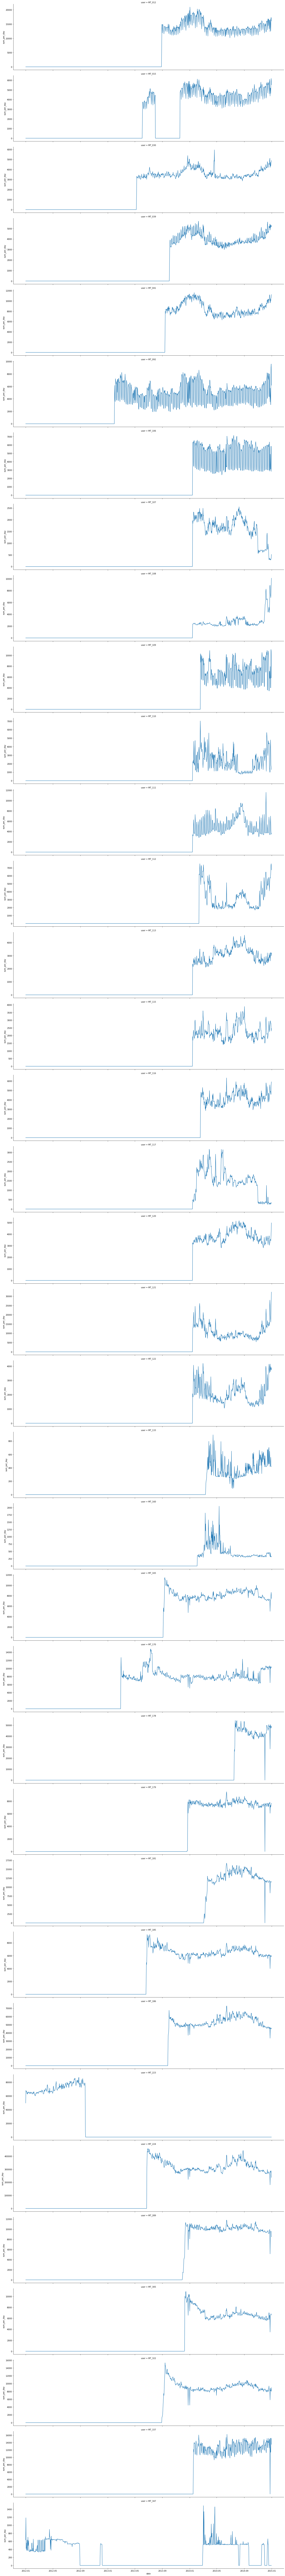

In [ ]:
def cleaning(dataframe, threshold=90): #some data cleaning stuff happening here
    dataframe = dataframe.copy(deep=True)

    dataframe = dataframe[dataframe.date.dt.year >= 2012] #just take data from 2012 or later
    # remove the extra day in leap year
    dataframe = dataframe[dataframe.date != pd.to_datetime('20120229')]


    def without_leading_consecutive_zeros(dataframe, threshold, by="user", col="sum_per_day"): #this function deals with people who started accounts beyond the start of the dataset -- should have a ton of zeros in a row before having real data
        # reference: https://datascience.stackexchange.com/questions/20587/find-the-consecutive-zeros-in-a-dataframe-and-do-a-conditional-replacement
        group = dataframe.groupby(by=by)[col].apply(lambda x: (~((x == x.shift()) & (x == 0))).cumsum())
        mask = dataframe[col].groupby(group).transform('count').lt(threshold)
        mask |= (group != 1)
        return mask

    ########## can implement above function below -- did not use for xgboost analysis, will need to rerun clusters if this is turned on

    # mask = without_leading_consecutive_zeros(dataframe, threshold)
    # print(f'dropping {(~mask).sum()} rows with leading zeros...')
    # dataframe = dataframe.loc[mask, :]

    # count 0 usage days -- just filter out people who had a ~year of inactivity
    zero_count = dataframe.groupby('user')['sum_per_day'].apply(lambda x: np.sum(x == 0))
    abnormal = zero_count[zero_count > 370]
    print(abnormal)

    #can use this to help you make a decision on cutoffs
    sns.relplot(data=dataframe[dataframe.user.isin(abnormal.index)], 
            x="date", y="sum_per_day", row="user",
            kind="line", aspect=4, facet_kws={'sharey': False})

    dataframe = dataframe[~dataframe.user.isin(abnormal.index)]

    return dataframe


df_day_clean = cleaning(df_day)

In [ ]:
df_day_clean.head()

,user,date,sum_per_day,std_per_day
365,MT_001,2012-01-01,715.736041,5.866965
366,MT_001,2012-01-02,1025.380711,7.726193
367,MT_001,2012-01-03,1040.609137,7.358141
368,MT_001,2012-01-04,1095.177665,7.545991
369,MT_001,2012-01-05,1351.522843,6.674789


## Create features

ex. lag, rolling statistics ... 

In [ ]:
def feature_engineering(dataframe_raw, drop_na = False, extended = False):

    dataframe = dataframe_raw.copy(deep=True)

    dataframe.sort_values(by=["user", "date"]).reset_index(drop=True, inplace=True)


    dataframe = dataframe.pipe(
        lambda x: x.assign(
           # feat_day_std = x["std_per_day"], data leak here if you include this 
           # feat_std_one_day_lag = x.groupby("user")["std_per_day"].shift(1), #found this not super useful
            #this vals are just lagged values  
            feat_one_day_lag = x.groupby("user")["sum_per_day"].shift(1),
            feat_one_week_lag = x.groupby("user")["sum_per_day"].shift(7),
            feat_one_month_lag = x.groupby("user")["sum_per_day"].shift(30),
            feat_three_month_lag = x.groupby("user")["sum_per_day"].shift(90),
            feat_one_year_lag = x.groupby("user")["sum_per_day"].shift(365),
            #these values are rolled up from the previous 7 or 30 days BEFORE the current day, not including the current (data leakage)
            feat_one_week_mean = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(8, closed= "left").mean()),
            feat_one_month_mean = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(31, closed= "left").mean()), 
            feat_one_week_std = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(8, closed= "left").std()),
            feat_one_month_std = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(31, closed= "left").std()),

        )
    )

    # can use this parameter to create more lagged features, from 1 day to 31 days
    if extended == True:
        for i in range(1,31):
            if i not in [1,7,30]:
                dataframe[f'feat_{i}_day_lag'] = dataframe.groupby("user")["sum_per_day"].shift(i)
                dataframe[f'feat_{i}_day_lag'] = pd.to_numeric(dataframe[f'feat_{i}_day_lag'])


    
    
    # drop nas
    if drop_na:
        dataframe = dataframe.dropna()
    
    # change from object to numeric -- need to do this before ingesting to model
    dataframe['feat_one_day_lag'] = pd.to_numeric(dataframe['feat_one_day_lag'])
    dataframe['feat_one_week_lag'] = pd.to_numeric(dataframe['feat_one_week_lag'])
    dataframe['feat_one_month_lag'] = pd.to_numeric(dataframe['feat_one_month_lag'])
    dataframe['feat_three_month_lag'] = pd.to_numeric(dataframe['feat_three_month_lag'])
    dataframe['feat_one_year_lag'] = pd.to_numeric(dataframe['feat_one_year_lag'])
    
    # expand date/time variables
    dataframe['feat_year'] = dataframe['date'].dt.year
    dataframe['feat_month'] = dataframe['date'].dt.month
    dataframe['feat_day'] = dataframe['date'].dt.day
    dataframe['day_of_week'] = dataframe['date'].dt.dayofweek
    dataframe[[f'feat_{dow}' for dow in ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']]] = pd.get_dummies(dataframe.day_of_week)

    return dataframe

df_day_feat = feature_engineering(df_day_clean)
df_day_feat.reset_index(drop=True, inplace=True)




In [ ]:
len(df_day_feat.user.unique())

334

## Create train/test splits

In [ ]:
train_test_cutoff = pd.to_datetime('20140401') 

train_start = df['timestamp'].min()
train_end = train_test_cutoff
test_start = train_test_cutoff
test_end = df['timestamp'].max()

df_train = df_day_feat.query("date < @train_test_cutoff").reset_index()
df_test = df_day_feat.query("date >= @train_test_cutoff").reset_index()

In [ ]:
print("Train-Test Cutoff: {}".format(train_test_cutoff))
print(
    "Training set: {},\nTest set:{}".format(df_train.shape, df_test.shape)
)
print("Percentage of data that is reserved for test: ", df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]))

Train-Test Cutoff: 2014-04-01 00:00:00
Training set: (273880, 25),
Test set:(91850, 25)
Percentage of data that is reserved for test:  0.2511415525114155


In [ ]:
df_train.head(10)

,index,user,date,sum_per_day,std_per_day,feat_one_day_lag,feat_one_week_lag,feat_one_month_lag,feat_three_month_lag,feat_one_year_lag,...,feat_month,feat_day,day_of_week,feat_Mon,feat_Tue,feat_Wed,feat_Thr,feat_Fri,feat_Sat,feat_Sun
0,0,MT_001,2012-01-01,715.736041,5.866965,NaN,NaN,NaN,NaN,NaN,...,1,1,6,0,0,0,0,0,0,1
1,1,MT_001,2012-01-02,1025.380711,7.726193,715.736041,NaN,NaN,NaN,NaN,...,1,2,0,1,0,0,0,0,0,0
2,2,MT_001,2012-01-03,1040.609137,7.358141,1025.380711,NaN,NaN,NaN,NaN,...,1,3,1,0,1,0,0,0,0,0
3,3,MT_001,2012-01-04,1095.177665,7.545991,1040.609137,NaN,NaN,NaN,NaN,...,1,4,2,0,0,1,0,0,0,0
4,4,MT_001,2012-01-05,1351.522843,6.674789,1095.177665,NaN,NaN,NaN,NaN,...,1,5,3,0,0,0,1,0,0,0
5,5,MT_001,2012-01-06,1331.218274,7.198192,1351.522843,NaN,NaN,NaN,NaN,...,1,6,4,0,0,0,0,1,0,0
6,6,MT_001,2012-01-07,1148.477157,7.128380,1331.218274,NaN,NaN,NaN,NaN,...,1,7,5,0,0,0,0,0,1,0
7,7,MT_001,2012-01-08,1064.720812,6.917165,1148.477157,715.736041,NaN,NaN,NaN,...,1,8,6,0,0,0,0,0,0,1
8,8,MT_001,2012-01-09,1159.898477,7.620843,1064.720812,1025.380711,NaN,NaN,NaN,...,1,9,0,1,0,0,0,0,0,0
9,9,MT_001,2012-01-10,1178.934010,7.568423,1159.898477,1040.609137,NaN,NaN,NaN,...,1,10,1,0,1,0,0,0,0,0


In [ ]:
features = list(df_train.columns[df_train.columns.str.startswith('feat_')])
target = 'sum_per_day'
print(f"Features: {features}, total {len(features)}\nTarget: {target}")

Features: ['feat_one_day_lag', 'feat_one_week_lag', 'feat_one_month_lag', 'feat_three_month_lag', 'feat_one_year_lag', 'feat_one_week_mean', 'feat_one_month_mean', 'feat_one_week_std', 'feat_one_month_std', 'feat_year', 'feat_month', 'feat_day', 'feat_Mon', 'feat_Tue', 'feat_Wed', 'feat_Thr', 'feat_Fri', 'feat_Sat', 'feat_Sun'], total 19
Target: sum_per_day


## Add Clusters

In [ ]:
# make sure this aligns with the clustering dataset! 

wide_df_train = df_train.pivot_table(index="user", columns="date", values="sum_per_day")\
    .dropna(axis=0)

valid_users = wide_df_train.index
valid_users

Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_361', 'MT_362', 'MT_363', 'MT_364', 'MT_365', 'MT_366', 'MT_367',
       'MT_368', 'MT_369', 'MT_370'],
      dtype='object', name='user', length=334)

In [ ]:
# results from local
labels = np.array([
    2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 
    2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 
    2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 
    1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 
    2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 
    1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2
])
labels

array([2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0,

In [ ]:
from IPython.core.display import HTML

user_clusters = pd.DataFrame(zip(valid_users, labels), columns=["user", "cluster"])

display(HTML(user_clusters.to_html()))

display_cluster = user_clusters.copy(deep=True)
display_cluster["idx"] = display_cluster.sort_values(["user", "cluster"]).groupby("cluster").cumcount()
display_cluster = pd.pivot_table(data=display_cluster, index="idx", columns="cluster", values="user", aggfunc=lambda x: ' '.join(x), fill_value="").add_prefix("cluster_")
display(HTML(display_cluster.to_html()))

,user,cluster
0,MT_001,2
1,MT_002,0
2,MT_003,1
3,MT_004,2
4,MT_005,2
5,MT_006,2
6,MT_007,2
7,MT_008,1
8,MT_009,2
9,MT_010,2


cluster,cluster_0,cluster_1,cluster_2
idx,,,
0,MT_002,MT_003,MT_001
1,MT_055,MT_008,MT_004
2,MT_091,MT_013,MT_005
3,MT_098,MT_022,MT_006
4,MT_099,MT_023,MT_007
5,MT_100,MT_029,MT_009
6,MT_101,MT_036,MT_010
7,MT_102,MT_040,MT_011
8,MT_103,MT_045,MT_014


Merge the cluster info with our main dataframes.

In [ ]:
df_train_with_cluster = df_train.merge(user_clusters, on='user')
df_test_with_cluster = df_test.merge(user_clusters, on='user')
df_train_with_cluster.head(10)

,index,user,date,sum_per_day,std_per_day,feat_one_day_lag,feat_one_week_lag,feat_one_month_lag,feat_three_month_lag,feat_one_year_lag,...,feat_day,day_of_week,feat_Mon,feat_Tue,feat_Wed,feat_Thr,feat_Fri,feat_Sat,feat_Sun,cluster
0,0,MT_001,2012-01-01,715.736041,5.866965,NaN,NaN,NaN,NaN,NaN,...,1,6,0,0,0,0,0,0,1,2
1,1,MT_001,2012-01-02,1025.380711,7.726193,715.736041,NaN,NaN,NaN,NaN,...,2,0,1,0,0,0,0,0,0,2
2,2,MT_001,2012-01-03,1040.609137,7.358141,1025.380711,NaN,NaN,NaN,NaN,...,3,1,0,1,0,0,0,0,0,2
3,3,MT_001,2012-01-04,1095.177665,7.545991,1040.609137,NaN,NaN,NaN,NaN,...,4,2,0,0,1,0,0,0,0,2
4,4,MT_001,2012-01-05,1351.522843,6.674789,1095.177665,NaN,NaN,NaN,NaN,...,5,3,0,0,0,1,0,0,0,2
5,5,MT_001,2012-01-06,1331.218274,7.198192,1351.522843,NaN,NaN,NaN,NaN,...,6,4,0,0,0,0,1,0,0,2
6,6,MT_001,2012-01-07,1148.477157,7.128380,1331.218274,NaN,NaN,NaN,NaN,...,7,5,0,0,0,0,0,1,0,2
7,7,MT_001,2012-01-08,1064.720812,6.917165,1148.477157,715.736041,NaN,NaN,NaN,...,8,6,0,0,0,0,0,0,1,2
8,8,MT_001,2012-01-09,1159.898477,7.620843,1064.720812,1025.380711,NaN,NaN,NaN,...,9,0,1,0,0,0,0,0,0,2
9,9,MT_001,2012-01-10,1178.934010,7.568423,1159.898477,1040.609137,NaN,NaN,NaN,...,10,1,0,1,0,0,0,0,0,2


In [ ]:
df_train_with_cluster.columns

Index(['index', 'user', 'date', 'sum_per_day', 'std_per_day',
       'feat_one_day_lag', 'feat_one_week_lag', 'feat_one_month_lag',
       'feat_three_month_lag', 'feat_one_year_lag', 'feat_one_week_mean',
       'feat_one_month_mean', 'feat_one_week_std', 'feat_one_month_std',
       'feat_year', 'feat_month', 'feat_day', 'day_of_week', 'feat_Mon',
       'feat_Tue', 'feat_Wed', 'feat_Thr', 'feat_Fri', 'feat_Sat', 'feat_Sun',
       'cluster'],
      dtype='object')

### Helper functions - viz

In [ ]:
# Plot prediction for user x

def plot_prediction(df, user = 'MT_001', target = "sum_per_day", time_interval = (20110102, 20150101)):
  
    #time_start = time_interval[0]
    #time_end = time_interval[1]
    ## subset time range
    #temp_df = dataframe.query("@time_start <= date <= @time_end").copy()
    #temp_df = temp_df.query("user == @user")
    # inference
    #y_hat = model.predict(temp_df[features])
    # plot
    df_filtered = df[df['user'] == user]
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df_filtered['date'], df_filtered['pred'], label='prediction')
    ax.plot(df_filtered['date'], df_filtered[target], label='actual', linestyle='-.', color='red')

    ax.set_xlabel("date")
    ax.set_ylabel("sum_per_day")
    ax.legend()

def plot_error(dataframe, model, user = 'MT_001', time_interval = (20110102, 20150101)):
    time_start = time_interval[0]
    time_end = time_interval[1]
    # subset time range
    temp_df = dataframe.query("@time_start <= date <= @time_end").copy()
    temp_df = temp_df.query("user == @user")
    # inference
    y_hat = model.predict(temp_df[features])
    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(temp_df['date'], y_hat - temp_df[target], label='residual')

    ax.set_xlabel("date")
    ax.set_ylabel("prediction_error")
    ax.legend()



In [ ]:
def mean_residual_per_day(dataframe, y_hat, y, user = 'All', time_interval = (20110102, 20150101), ax = None, label = None):
    time_start = time_interval[0]
    time_end = time_interval[1]

    # subset time range
    temp_df = dataframe.query("@time_start <= date <= @time_end").copy()
    if user != 'All' and user[:2] == 'MT':
        temp_df = temp_df.query("user == @user")

    # temp_df['date'] = temp_df['timestamp'].dt.date

    # inference
    temp_df['residual'] = np.abs(y_hat - y)
    
    # plot
    if ax is None:
        raise ValueError("ax is None")
    
    ax.plot(temp_df.groupby('date')['residual'].mean().index, temp_df.groupby('date')['residual'].mean().values, label=label)




### Function: create train/test splits accomodate users across sets by cluster

In [ ]:
def train_test_split_by_cluster(df_train, df_test, cluster_index, target, shuffle=True):
    df_train_subset = df_train.query("cluster == @cluster_index")
    df_test_subset = df_test.query("cluster == @cluster_index")

    if shuffle:
        df_train_subset = df_train_subset.sample(frac=1, random_state=0).reset_index(drop=True)
        df_test_subset = df_test_subset.sample(frac=1, random_state=0).reset_index(drop=True)

    X_train = df_train_subset.drop([target], axis = 1)
    y_train = df_train_subset[target]
    X_test = df_test_subset.drop([target], axis = 1)
    y_test = df_test_subset[target]
    
    return X_train, X_test, y_train, y_test

# Modeling


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
import warnings 
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline

warnings.simplefilter(action='ignore')

In [ ]:
df_train.columns

Index(['index', 'user', 'date', 'sum_per_day', 'std_per_day',
       'feat_one_day_lag', 'feat_one_week_lag', 'feat_one_month_lag',
       'feat_three_month_lag', 'feat_one_year_lag', 'feat_one_week_mean',
       'feat_one_month_mean', 'feat_one_week_std', 'feat_one_month_std',
       'feat_year', 'feat_month', 'feat_day', 'day_of_week', 'feat_Mon',
       'feat_Tue', 'feat_Wed', 'feat_Thr', 'feat_Fri', 'feat_Sat', 'feat_Sun'],
      dtype='object')

### Create modified train/test splits, separated into features and response

In [ ]:
df_X_train = df_train.drop(['sum_per_day'], axis=1)
df_y_train = df_train['sum_per_day']

df_X_test = df_test.drop(['sum_per_day'], axis=1)
df_y_test = df_test['sum_per_day']

df_X_train.columns
df_X_train.dtypes

index                            int64
user                            object
date                    datetime64[ns]
std_per_day                    float64
feat_one_day_lag               float64
feat_one_week_lag              float64
feat_one_month_lag             float64
feat_three_month_lag           float64
feat_one_year_lag              float64
feat_one_week_mean             float64
feat_one_month_mean            float64
feat_one_week_std              float64
feat_one_month_std             float64
feat_year                        int64
feat_month                       int64
feat_day                         int64
day_of_week                      int64
feat_Mon                         uint8
feat_Tue                         uint8
feat_Wed                         uint8
feat_Thr                         uint8
feat_Fri                         uint8
feat_Sat                         uint8
feat_Sun                         uint8
dtype: object

### Default XGB

In [ ]:

drop_cols = ['date','index','user','std_per_day'] #delete columns we dont use


preprocess_no_user = make_column_transformer(('drop', drop_cols),
                                     remainder = 'passthrough') #won't break is missing something
#combining whats above (like recipe)


pipe_xgb_no_user = make_pipeline(preprocess_no_user,
                         #IterativeImputer(), #this part would replace NA but no need for xgboost
                         XGBRegressor( eval_metric='mape',
                                       tree_method = 'gpu_hist'
                                     ))                       
start_time = time.time()


pipe_xgb_no_user.fit(df_X_train, df_y_train)

print("Train score:", pipe_xgb_no_user.score(df_X_train, df_y_train))
print("Test score:", pipe_xgb_no_user.score(df_X_test, df_y_test))

print("--- %s seconds ---" % (time.time() - start_time))

Train score: 0.9943262369763864
Test score: 0.983347672238962
--- 1.3053991794586182 seconds ---


Train MAPE:  0.09754638996452598
Train RMSE:  23595.985654231416
Test MAPE:  0.08465847246735218
Test RMSE:  43367.28435284266


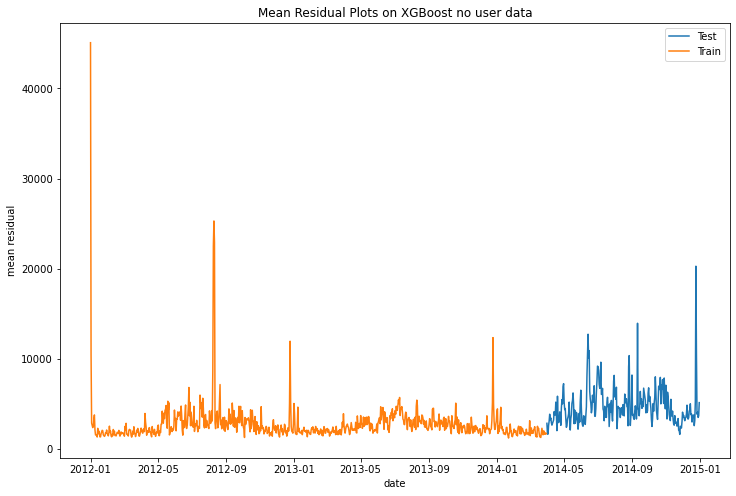

In [ ]:
#here we create some viz and mape outputs for the above model

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


fig, ax = plt.subplots(figsize=(12, 8))

df_y_train_pred = pipe_xgb_no_user.predict(df_X_train)
df_y_test_pred = pipe_xgb_no_user.predict(df_X_test)

mean_residual_per_day(df_test, pipe_xgb_no_user, user = 'All', y = df_y_test, y_hat = df_y_test_pred, time_interval = (test_start, test_end), ax = ax, label = 'Test')
mean_residual_per_day(df_train, pipe_xgb_no_user, user = 'All', y = df_y_train, y_hat = df_y_train_pred, time_interval = (train_start, train_end), ax = ax, label = 'Train')
ax.set_xlabel("date")
ax.set_ylabel("mean residual")
ax.set_title("Mean Residual Plots on XGBoost no user data")
ax.legend()

print("Train MAPE: ", mean_absolute_percentage_error(df_y_train_pred, df_y_train))
print("Train RMSE: ", mean_squared_error(df_y_train_pred, df_y_train, squared=False))

print("Test MAPE: ", mean_absolute_percentage_error(df_y_test_pred, df_y_test))
print("Test RMSE: ", mean_squared_error(df_y_test_pred, df_y_test, squared=False))


In [ ]:
import shap
# this is to create a SHAP plot for the above model, basically just feature importances 
df_X_test_wide = pd.DataFrame(preprocess_no_user.transform(df_X_test), columns = pipe_xgb_no_user[:-1].get_feature_names_out())


explainer = shap.TreeExplainer(pipe_xgb_no_user['xgbregressor'])


shap_values = explainer.shap_values(df_X_test_wide)
shap.summary_plot(shap_values, df_X_test_wide, plot_type="bar")

(275, 24)
        index    user       date   sum_per_day  std_per_day  feat_one_day_lag  \
0         820  MT_001 2014-04-01  3.159898e+02     2.838116      2.538071e+02   
1         821  MT_001 2014-04-02  2.335025e+02     1.847438      3.159898e+02   
2         822  MT_001 2014-04-03  2.423858e+02     2.079090      2.335025e+02   
3         823  MT_001 2014-04-04  6.332487e+02     7.210840      2.423858e+02   
4         824  MT_001 2014-04-05  1.624365e+02     0.914497      6.332487e+02   
...       ...     ...        ...           ...          ...               ...   
91845  365725  MT_370 2014-12-27  1.439351e+06  1242.717435      1.200378e+06   
91846  365726  MT_370 2014-12-28  1.556000e+06  1805.675897      1.439351e+06   
91847  365727  MT_370 2014-12-29  1.805676e+06  1658.016491      1.556000e+06   
91848  365728  MT_370 2014-12-30  1.867514e+06  1194.166998      1.805676e+06   
91849  365729  MT_370 2014-12-31  1.355892e+06  3819.896087      1.867514e+06   

       feat_one_w

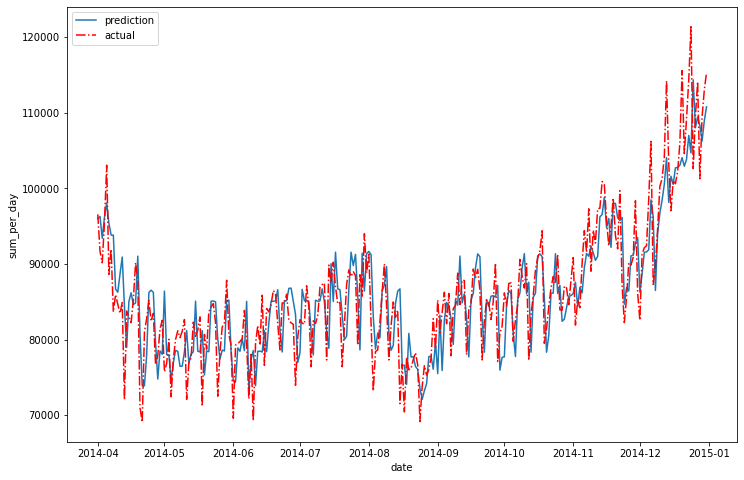

In [ ]:
#plot predictions for a single user against real vals to get idea of how it fit

df_test_pred = df_test.copy(deep=True)
df_test_pred['pred'] = df_y_test_pred

print(df_test_pred)
plot_prediction(df = df_test_pred, user = "MT_049", target = "sum_per_day", time_interval = (pd.to_datetime("20130801"), pd.to_datetime("20130831")))


### including user data

In [ ]:
# this trains on the user id info, tried this to see if it would increase signal

drop_cols = ['date','index','user','std_per_day']

ohe_features = ['user']


preprocess = make_column_transformer(('drop', drop_cols),
                                     (OneHotEncoder(handle_unknown = 'ignore'), ohe_features), #specify which column we want
                                     remainder = 'passthrough') #won't break is missing something
#combining whats above (like recipe)


pipe_xgb = make_pipeline(preprocess, #step 1
                         #IterativeImputer(), #this part would replace NA
                         XGBRegressor( eval_metric='mape',
                                       tree_method = 'gpu_hist'
                                     ))                
start_time = time.time()


model = XGBRegressor(eval_metric='mape',
           tree_method = 'gpu_hist'
         #learning_rate = 0.05, 
         # max_depth = 11, 
         # min_child_weight = 0.1, 
         # subsample = 0.5
         ) 


pipe_xgb.fit(df_X_train, df_y_train)

print("Train score:", pipe_xgb.score(df_X_train, df_y_train))
print("Test score:", pipe_xgb.score(df_X_test, df_y_test))

print("--- %s seconds ---" % (time.time() - start_time))

Train score: 0.9986721113621354
Test score: 0.9847949664884489
--- 2.106590986251831 seconds ---


Training MAPE: 0.1158
Test MAPE:  0.13387161560821384


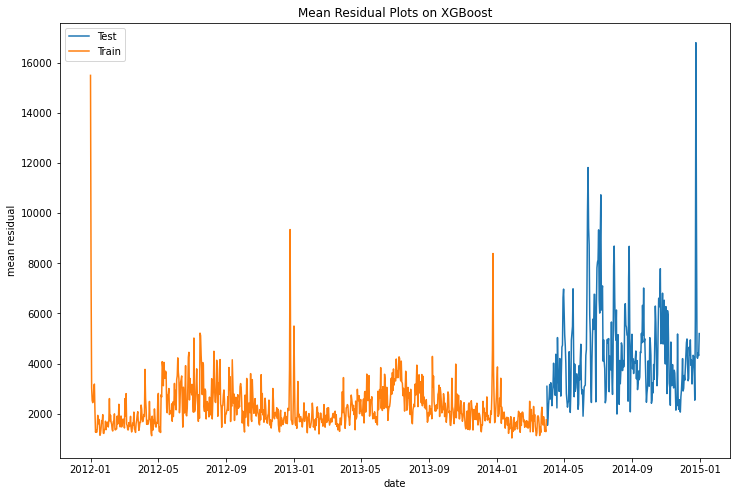

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(12, 8))

df_y_train_pred = pipe_xgb.predict(df_X_train)
df_y_test_pred = pipe_xgb.predict(df_X_test)

mean_residual_per_day(df_test, pipe_xgb, user = 'All', y = df_y_test, y_hat = df_y_test_pred, time_interval = (test_start, test_end), ax = ax, label = 'Test')
mean_residual_per_day(df_train, pipe_xgb, user = 'All', y = df_y_train, y_hat = df_y_train_pred, time_interval = (train_start, train_end), ax = ax, label = 'Train')
ax.set_xlabel("date")
ax.set_ylabel("mean residual")
ax.set_title("Mean Residual Plots on XGBoost")
ax.legend()

print(f"Training MAPE: {mean_absolute_percentage_error(df_y_train_pred, df_y_train):.4f}")

print("Test MAPE: ", mean_absolute_percentage_error(df_y_test_pred, df_y_test))



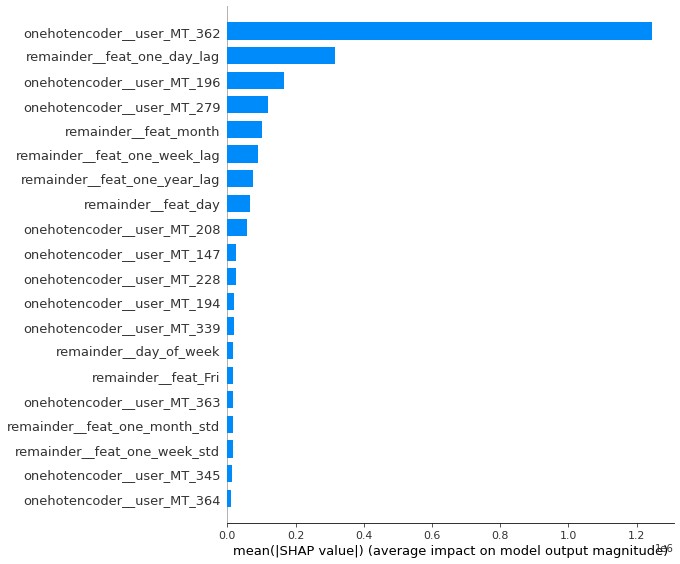

In [ ]:
import shap
df_X_test_wide = pd.DataFrame(preprocess.transform(df_X_test).toarray(), columns = pipe_xgb[:-1].get_feature_names_out())


explainer = shap.TreeExplainer(pipe_xgb['xgbregressor'])


shap_values = explainer.shap_values(df_X_test_wide)
shap.summary_plot(shap_values, df_X_test_wide, plot_type="bar")

### XGB with cluster

Cross validation R2 score with 5 folds for cluster = 0: [0.99291758 0.9943968  0.99246161 0.99448507 0.99361713]
R2 score on testing sets for cluster = 0: 0.9825
Training MAPE: 0.0485
Testing MAPE:  0.0613
8.615079198471106e+16
Cross validation R2 score with 5 folds for cluster = 1: [0.9930711  0.99235629 0.99531427 0.99396052 0.99423107]
R2 score on testing sets for cluster = 1: 0.9838
Training MAPE: 0.1501
Testing MAPE:  0.1902
1.043494009230876e+16
Cross validation R2 score with 5 folds for cluster = 2: [0.98027374 0.97353827 0.98228741 0.98223652 0.97686743]
R2 score on testing sets for cluster = 2: 0.9765
Training MAPE: 0.1390
Testing MAPE:  0.0888
5.925463963287505e+16
--- 14.949775457382202 seconds ---


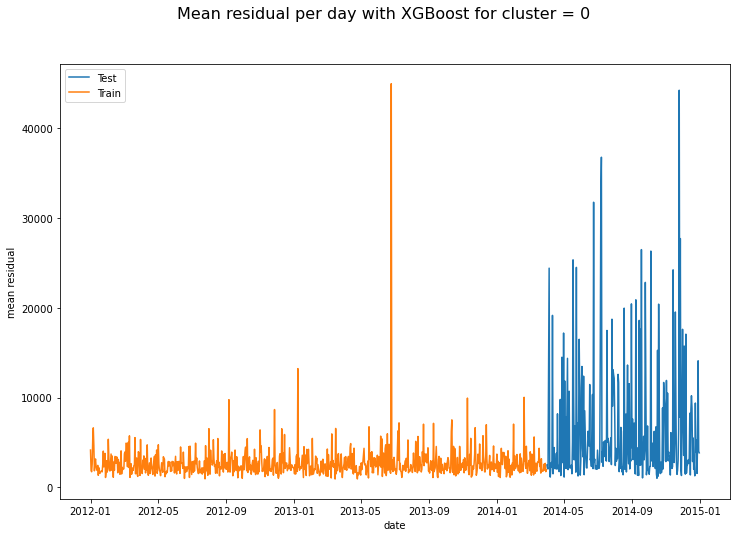

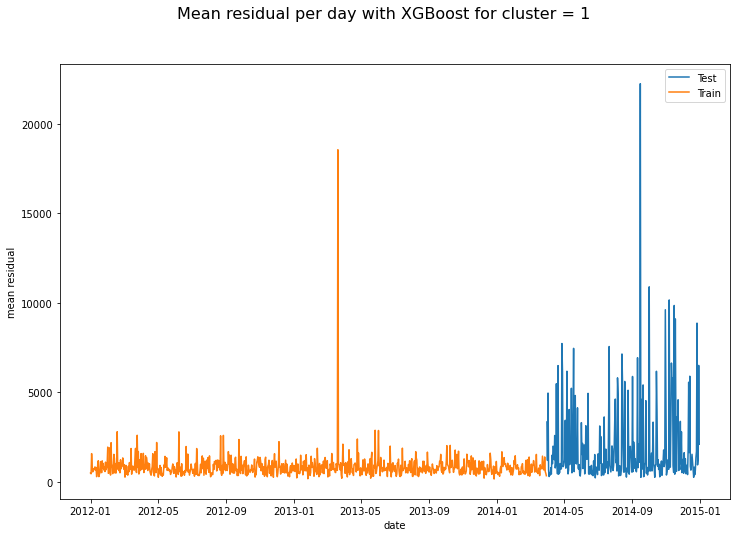

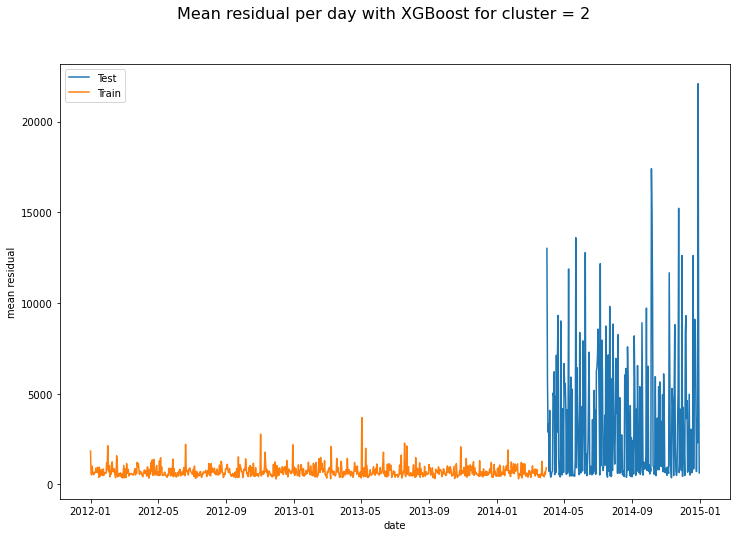

In [ ]:
# Create baseline model for each cluster to see if clustering info changes performance
dt_models = [] 


start_time = time.time()

k = 3

for i in range(k):
    X_train, X_test, y_train, y_test = train_test_split_by_cluster(df_train_with_cluster, df_test_with_cluster, cluster_index=i, target='sum_per_day')
    pipe_xgb_cluster = make_pipeline(preprocess_no_user, #step 1
                         #IterativeImputer(), #this part would replace NA
                         XGBRegressor(eval_metric='mape',
                                      tree_method = 'gpu_hist'

                                     ))  
    pipe_xgb_cluster.fit(X_train, y_train)
    
    print(f"Cross validation R2 score with 5 folds for cluster = {i}: {cross_val_score(pipe_xgb_cluster, X_train, y_train)}")
    print(f"R2 score on testing sets for cluster = {i}: {pipe_xgb_cluster.score(X_test, y_test):.4f}")
    y_train_pred = pipe_xgb_cluster.predict(X_train)
    y_test_pred = pipe_xgb_cluster.predict(X_test)
    print(f"Training MAPE: {mean_absolute_percentage_error(y_train_pred, y_train):.4f}")
    print(f"Testing MAPE:  {mean_absolute_percentage_error(y_test_pred, y_test):.4f}")
    
    # plot 
    fig, ax = plt.subplots(figsize=(12, 8))

    mean_residual_per_day(df_test_with_cluster.query("cluster == @i"),  pipe_xgb_cluster, y = y_test, y_hat = y_test_pred, user = 'All', time_interval = (test_start, test_end), ax = ax, label = 'Test')
    mean_residual_per_day(df_train_with_cluster.query("cluster == @i"),  pipe_xgb_cluster, y = y_train, y_hat = y_train_pred,  user = 'All', time_interval = (train_start, train_end), ax = ax, label = 'Train')
    ax.set_xlabel("date")
    ax.set_ylabel("mean residual")
    plt.suptitle(f"Mean residual per day with XGBoost for cluster = {i}", fontsize=16)
    ax.legend()

    dt_models.append(pipe_xgb_cluster)
    
print("--- %s seconds ---" % (time.time() - start_time))


### Random Forest

In [ ]:
# all RF testing follows exactly same scheme as xgboost -- needs imputer though
# warning: takes much longer than xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer


pipe_rf = make_pipeline(preprocess_no_user, 
                        SimpleImputer(strategy = 'median', fill_value = 0),
                          RandomForestRegressor(
                                     ))                       
start_time = time.time()



pipe_rf.fit(df_X_train, df_y_train)

print("Train score:", pipe_rf.score(df_X_train, df_y_train))
print("Test score:", pipe_rf.score(df_X_test, df_y_test))

print("--- %s seconds ---" % (time.time() - start_time))


df_y_test_pred = pipe_rf.predict(df_X_test)

print("Test MAPE: ", mean_absolute_percentage_error(df_y_test_pred, df_y_test))
print("Test RMSE: ", mean_squared_error(df_y_test_pred, df_y_test, squared=False))

Train score: 0.9989382251389343
Test score: 0.9943962492351963
--- 366.0904154777527 seconds ---
Test MAPE:  0.057891065183087356
Test RMSE:  25157.307487658407


Test MAPE:  0.057891065183087356
Test RMSE:  25157.307487658407


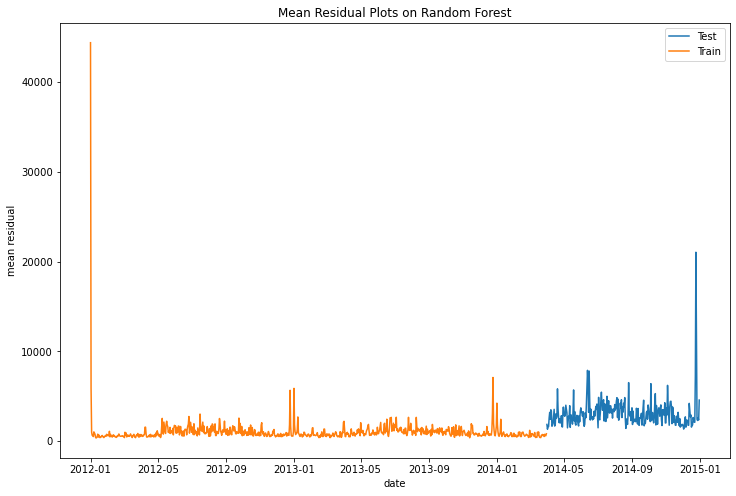

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(12, 8))

df_y_train_pred = pipe_rf.predict(df_X_train)
df_y_test_pred = pipe_rf.predict(df_X_test)

mean_residual_per_day(df_test, pipe_rf, user = 'All', y = df_y_test, y_hat = df_y_test_pred, time_interval = (test_start, test_end), ax = ax, label = 'Test')
mean_residual_per_day(df_train, pipe_rf, user = 'All', y = df_y_train, y_hat = df_y_train_pred, time_interval = (train_start, train_end), ax = ax, label = 'Train')
ax.set_xlabel("date")
ax.set_ylabel("mean residual")
ax.set_title("Mean Residual Plots on Random Forest")
ax.legend()


print("Test MAPE: ", mean_absolute_percentage_error(df_y_test_pred, df_y_test))
print("Test RMSE: ", mean_squared_error(df_y_test_pred, df_y_test, squared=False))



Cross validation R2 score with 5 folds for cluster = 0: [0.99493969 0.99606318 0.99463258 0.99640103 0.99404892]
R2 score on testing sets for cluster = 0: 0.9949
Training MAPE: 0.0149
Testing MAPE:  0.0404
Cross validation R2 score with 5 folds for cluster = 1: [0.99320122 0.99127074 0.99489209 0.99441977 0.9943101 ]
R2 score on testing sets for cluster = 1: 0.9904
Training MAPE: 0.0503
Testing MAPE:  0.1324
Cross validation R2 score with 5 folds for cluster = 2: [0.98825788 0.98186255 0.98425969 0.98764993 0.9870995 ]
R2 score on testing sets for cluster = 2: 0.9885
Training MAPE: 0.0220
Testing MAPE:  0.1162
--- 1530.8178234100342 seconds ---


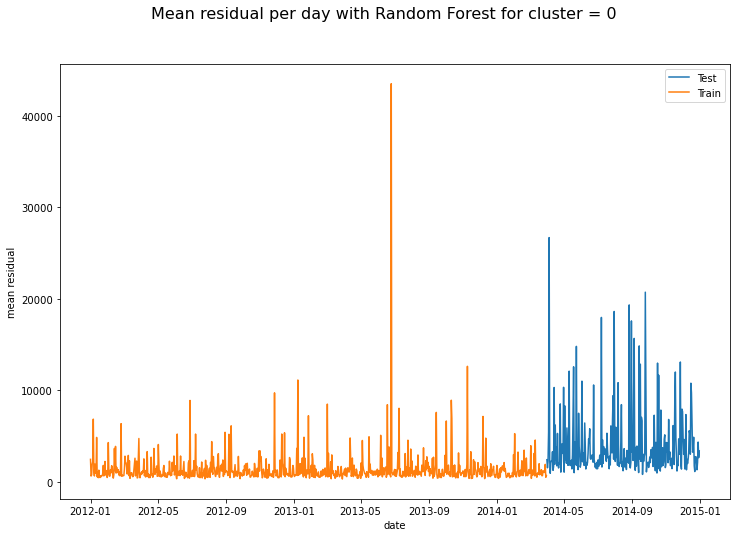

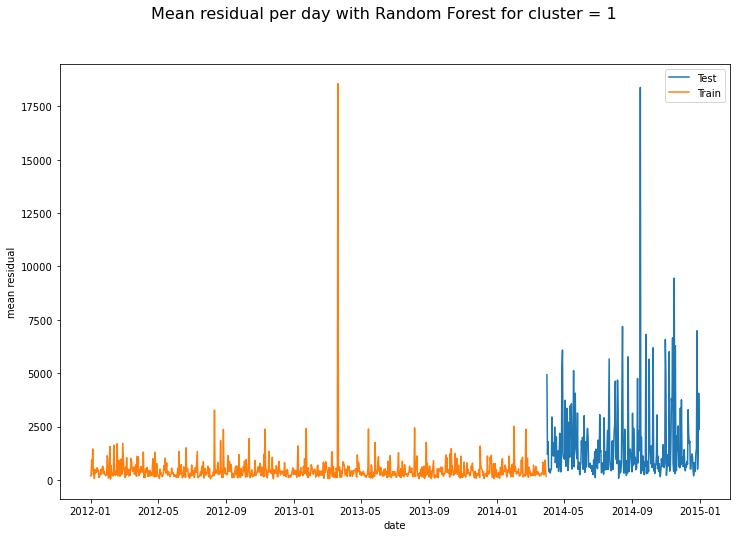

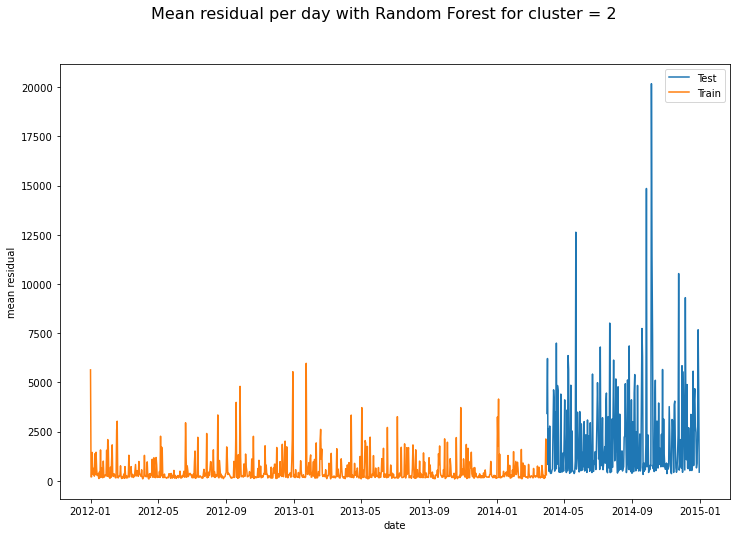

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Create baseline model for each cluster
rf_models = [] 


start_time = time.time()

k = 3

for i in range(k):
    X_train, X_test, y_train, y_test = train_test_split_by_cluster(df_train_with_cluster, df_test_with_cluster, cluster_index=i, target='sum_per_day')
    pipe_rf_cluster = make_pipeline(preprocess_no_user, #step 1
                            SimpleImputer(strategy = 'median', fill_value = 0),
                              RandomForestRegressor(
                                         ))  #step 2    
    pipe_rf_cluster.fit(X_train, y_train)
    
    print(f"Cross validation R2 score with 5 folds for cluster = {i}: {cross_val_score(pipe_rf_cluster, X_train, y_train)}")
    print(f"R2 score on testing sets for cluster = {i}: {pipe_rf_cluster.score(X_test, y_test):.4f}")
    y_train_pred = pipe_rf_cluster.predict(X_train)
    y_test_pred = pipe_rf_cluster.predict(X_test)
    print(f"Training MAPE: {mean_absolute_percentage_error(y_train_pred, y_train):.4f}")
    print(f"Testing MAPE:  {mean_absolute_percentage_error(y_test_pred, y_test):.4f}")
    
    # plot 
    fig, ax = plt.subplots(figsize=(12, 8))

    mean_residual_per_day(df_test_with_cluster.query("cluster == @i"),  pipe_rf_cluster, y = y_test, y_hat = y_test_pred, user = 'All', time_interval = (test_start, test_end), ax = ax, label = 'Test')
    mean_residual_per_day(df_train_with_cluster.query("cluster == @i"),  pipe_rf_cluster, y = y_train, y_hat = y_train_pred,  user = 'All', time_interval = (train_start, train_end), ax = ax, label = 'Train')
    ax.set_xlabel("date")
    ax.set_ylabel("mean residual")
    plt.suptitle(f"Mean residual per day with Random Forest for cluster = {i}", fontsize=16)
    ax.legend()

    dt_models.append(pipe_rf_cluster)
    
print("--- %s seconds ---" % (time.time() - start_time))


### Bayes search

In [ ]:
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV

#training and modeling part of the pipeline
#two steps: transform the data, train the model



param_test1 = {
 'xgbregressor__subsample':(0.5,1),
 'xgbregressor__min_child_weight':(0.1,3),
 'xgbregressor__learning_rate':(.05,.3),
  'xgbregressor__max_depth':(6,14),


}
                 
start_time = time.time()

#bayes takes a range of param_test1 and finds the best combination for you

bayes = BayesSearchCV(estimator = pipe_xgb_no_user,
                      search_spaces = param_test1,
                      random_state = 42, verbose=3) #random_state just repeats the same thing any number



bayes.fit(df_X_train, df_y_train) #this step does all the training
#does 5-fold cross permutation 
#cross validates among the training group 

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbregressor__learning_rate=0.15252598971332848, xgbregressor__max_depth=12, xgbregressor__min_child_weight=2.8053171966587183, xgbregressor__subsample=0.6578997967435244;, score=0.987 total time=   6.6s
[CV 2/5] END xgbregressor__learning_rate=0.15252598971332848, xgbregressor__max_depth=12, xgbregressor__min_child_weight=2.8053171966587183, xgbregressor__subsample=0.6578997967435244;, score=0.989 total time=   6.5s
[CV 3/5] END xgbregressor__learning_rate=0.15252598971332848, xgbregressor__max_depth=12, xgbregressor__min_child_weight=2.8053171966587183, xgbregressor__subsample=0.6578997967435244;, score=0.495 total time=   6.2s
[CV 4/5] END xgbregressor__learning_rate=0.15252598971332848, xgbregressor__max_depth=12, xgbregressor__min_child_weight=2.8053171966587183, xgbregressor__subsample=0.6578997967435244;, score=0.915 total time=   6.7s
[CV 5/5] END xgbregressor__learning_rate=0.15252598971332848, xgbregresso

[CV 2/5] END xgbregressor__learning_rate=0.18585076692257813, xgbregressor__max_depth=13, xgbregressor__min_child_weight=1.5397534404304787, xgbregressor__subsample=0.9188282185302634;, score=0.982 total time=  13.1s
[CV 3/5] END xgbregressor__learning_rate=0.18585076692257813, xgbregressor__max_depth=13, xgbregressor__min_child_weight=1.5397534404304787, xgbregressor__subsample=0.9188282185302634;, score=0.376 total time=  12.5s
[CV 4/5] END xgbregressor__learning_rate=0.18585076692257813, xgbregressor__max_depth=13, xgbregressor__min_child_weight=1.5397534404304787, xgbregressor__subsample=0.9188282185302634;, score=0.903 total time=  14.4s
[CV 5/5] END xgbregressor__learning_rate=0.18585076692257813, xgbregressor__max_depth=13, xgbregressor__min_child_weight=1.5397534404304787, xgbregressor__subsample=0.9188282185302634;, score=0.616 total time=  15.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbregressor__learning_rate=0.28886949657748207, xgbregresso

[CV 4/5] END xgbregressor__learning_rate=0.15687107323749358, xgbregressor__max_depth=12, xgbregressor__min_child_weight=1.9712805561390039, xgbregressor__subsample=0.5;, score=0.919 total time=   6.6s
[CV 5/5] END xgbregressor__learning_rate=0.15687107323749358, xgbregressor__max_depth=12, xgbregressor__min_child_weight=1.9712805561390039, xgbregressor__subsample=0.5;, score=0.613 total time=   7.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbregressor__learning_rate=0.0510100482967999, xgbregressor__max_depth=14, xgbregressor__min_child_weight=1.9998222854781724, xgbregressor__subsample=0.5;, score=0.986 total time=  15.0s
[CV 2/5] END xgbregressor__learning_rate=0.0510100482967999, xgbregressor__max_depth=14, xgbregressor__min_child_weight=1.9998222854781724, xgbregressor__subsample=0.5;, score=0.989 total time=  14.9s
[CV 3/5] END xgbregressor__learning_rate=0.0510100482967999, xgbregressor__max_depth=14, xgbregressor__min_child_weight=1.9998222854781

[CV 4/5] END xgbregressor__learning_rate=0.12189360028661822, xgbregressor__max_depth=6, xgbregressor__min_child_weight=0.3685128393563246, xgbregressor__subsample=0.5;, score=0.930 total time=   0.7s
[CV 5/5] END xgbregressor__learning_rate=0.12189360028661822, xgbregressor__max_depth=6, xgbregressor__min_child_weight=0.3685128393563246, xgbregressor__subsample=0.5;, score=0.675 total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbregressor__learning_rate=0.06013732846790915, xgbregressor__max_depth=6, xgbregressor__min_child_weight=0.8636794031848009, xgbregressor__subsample=0.5;, score=0.987 total time=   0.8s
[CV 2/5] END xgbregressor__learning_rate=0.06013732846790915, xgbregressor__max_depth=6, xgbregressor__min_child_weight=0.8636794031848009, xgbregressor__subsample=0.5;, score=0.992 total time=   0.8s
[CV 3/5] END xgbregressor__learning_rate=0.06013732846790915, xgbregressor__max_depth=6, xgbregressor__min_child_weight=0.863679403184800

[CV 4/5] END xgbregressor__learning_rate=0.1666923045840082, xgbregressor__max_depth=9, xgbregressor__min_child_weight=0.11483590642113727, xgbregressor__subsample=0.9935429614757261;, score=0.911 total time=   2.4s
[CV 5/5] END xgbregressor__learning_rate=0.1666923045840082, xgbregressor__max_depth=9, xgbregressor__min_child_weight=0.11483590642113727, xgbregressor__subsample=0.9935429614757261;, score=0.643 total time=   2.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__min_child_weight=0.6014802814073471, xgbregressor__subsample=0.5;, score=0.987 total time=   0.7s
[CV 2/5] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__min_child_weight=0.6014802814073471, xgbregressor__subsample=0.5;, score=0.991 total time=   0.7s
[CV 3/5] END xgbregressor__learning_rate=0.3, xgbregressor__max_depth=6, xgbregressor__min_child_weight=0.6014802814073471, xgbregressor__s

[CV 5/5] END xgbregressor__learning_rate=0.051853227426301225, xgbregressor__max_depth=12, xgbregressor__min_child_weight=0.2207274217704322, xgbregressor__subsample=0.5031144820304047;, score=0.609 total time=  11.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbregressor__learning_rate=0.11855273452729433, xgbregressor__max_depth=7, xgbregressor__min_child_weight=0.1, xgbregressor__subsample=0.5;, score=0.987 total time=   1.3s
[CV 2/5] END xgbregressor__learning_rate=0.11855273452729433, xgbregressor__max_depth=7, xgbregressor__min_child_weight=0.1, xgbregressor__subsample=0.5;, score=0.993 total time=   1.2s
[CV 3/5] END xgbregressor__learning_rate=0.11855273452729433, xgbregressor__max_depth=7, xgbregressor__min_child_weight=0.1, xgbregressor__subsample=0.5;, score=0.648 total time=   1.2s
[CV 4/5] END xgbregressor__learning_rate=0.11855273452729433, xgbregressor__max_depth=7, xgbregressor__min_child_weight=0.1, xgbregressor__subsample=0.5;, score=0.92

[CV 5/5] END xgbregressor__learning_rate=0.11407432305967107, xgbregressor__max_depth=7, xgbregressor__min_child_weight=0.3959871819165287, xgbregressor__subsample=0.5378839300189031;, score=0.653 total time=   1.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgbregressor__learning_rate=0.05, xgbregressor__max_depth=9, xgbregressor__min_child_weight=1.3782029735443497, xgbregressor__subsample=0.5;, score=0.987 total time=   3.2s
[CV 2/5] END xgbregressor__learning_rate=0.05, xgbregressor__max_depth=9, xgbregressor__min_child_weight=1.3782029735443497, xgbregressor__subsample=0.5;, score=0.991 total time=   3.0s
[CV 3/5] END xgbregressor__learning_rate=0.05, xgbregressor__max_depth=9, xgbregressor__min_child_weight=1.3782029735443497, xgbregressor__subsample=0.5;, score=0.656 total time=   2.9s
[CV 4/5] END xgbregressor__learning_rate=0.05, xgbregressor__max_depth=9, xgbregressor__min_child_weight=1.3782029735443497, xgbregressor__subsample=0.5;, score=0.922 

In [ ]:
print("Best params:", bayes.best_params_)
print("Best score:", bayes.best_score_)

print("Dev score:", bayes.score(df_X_train, df_y_train)) #how good is it predicting against the data its already seen
print("Test score:", bayes.score(df_X_test, df_y_test))

df_y_test_pred = bayes.predict(df_X_test)

print("Test MAPE: ", mean_absolute_percentage_error(df_y_test_pred, df_y_test))
print("Test RMSE: ", mean_squared_error(df_y_test_pred, df_y_test, squared=False))

Best params: OrderedDict([('xgbregressor__learning_rate', 0.12189360028661822), ('xgbregressor__max_depth', 6), ('xgbregressor__min_child_weight', 0.3685128393563246), ('xgbregressor__subsample', 0.5)])
Best score: 0.8481295151656129
Dev score: 0.9932243352776231
Test score: 0.9838059363455626
Test MAPE:  0.08377897184441538
Test RMSE:  42766.39801044828


### Bayes search with user data

In [ ]:
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV



######## could expand the search space to tune further!!!!
param_test1 = {
 'xgbregressor__subsample':(0.5,1),
 'xgbregressor__min_child_weight':(0.1,3),
 'xgbregressor__learning_rate':(.05,.3),
  'xgbregressor__max_depth':(6,14),


}
#learning rate, depth and child_weight 
#trains the model on the combo of these things

start_time = time.time()

#bayes takes a range of param_test1 and finds the best combination for you

bayes_oh = BayesSearchCV(estimator = pipe_xgb,
                      search_spaces = param_test1,
                      #scoring = 'rmse',
                      random_state = 42, verbose=3) #random_state just repeats the same thing any number



bayes_oh.fit(df_X_train, df_y_train) #this step does all the training
#does 5-fold cross permutation 
#cross validates among the training group 

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print("Best params:", bayes_oh.best_params_)
print("Best score:", bayes_oh.best_score_)

print("Dev score:", bayes_oh.score(df_X_train, df_y_train)) 
print("Test score:", bayes_oh.score(df_X_test, df_y_test))

df_y_test_pred = bayes_oh.predict(df_X_test)

# does better when tuned but takes forever
print("Test MAPE: ", mean_absolute_percentage_error(df_y_test_pred, df_y_test))
print("Test RMSE: ", mean_squared_error(df_y_test_pred, df_y_test, squared=False))

Best params: OrderedDict([('xgbregressor__learning_rate', 0.1250880872227118), ('xgbregressor__max_depth', 14), ('xgbregressor__min_child_weight', 3.0), ('xgbregressor__subsample', 0.5)])
Best score: 0.8198372994195118
Dev score: 0.9997321507511431
Test score: 0.9853450542719916
Test MAPE:  0.053206055722215845
Test RMSE:  39918.99276955886


## Rolling Eval

This functionality is inefficient and somewhat hacky -- there is almost certainly a better way to engineer this. Given the time constraints it was what we settled with to get us results. 

In [ ]:
import datetime

day_one = pd.to_datetime("20140401") #first predicted value -- does not use any predicted values in input


# start by predicting the first day
day_one_x = df_X_test[df_X_test["date"] == day_one]

day_one_y = pipe_xgb.predict(day_one_x)

day_one_df = day_one_x

day_one_df['sum_per_day'] = day_one_y


######



year_before_zero = df_train.query('date >= 20130101') #already is everything before 2014, just make the dataset a bit smaller by removing extra vals before 2013

rolling_df = year_before_zero.append(day_one_df).reset_index(drop = True) #add first predicted day to everything before it




#######

# used for debug
#num_predicted_days = (df_test['date'].max() - rolling_df['date'].max()).days

day_predict = df_test.date.min() #this is the first day of prediction (we will start the loop on the day after)

# basically loop through every day in sequence until the end
while day_predict != df_test.date.max():
    day_before = rolling_df.date.max()

    day_predict = day_before + datetime.timedelta(days=1) # move along to next day

    print(day_predict) #for debug

    day_predict_x = df_X_test[df_X_test["date"] == day_predict] #get all the inputs we need to predict for the next day




    rolling_df = rolling_df.append(day_predict_x) # add ONLY inputs of next day to the rolling df

    rolling_df = feature_engineering(rolling_df) # update the inputs -- some may change from line above to predicted values 

    day_predict_x_updated = rolling_df[rolling_df["date"] == day_predict] # isolate updated inputs that may contain predictions
    
    day_predict_y = pipe_xgb.predict(day_predict_x_updated) # predict on inputs

    day_predict_df = day_predict_x_updated 

    day_predict_df['sum_per_day'] = day_predict_y # combine to df
    
    rolling_df = rolling_df[rolling_df['date'] != day_predict] # remove the row with just inputs from bottom of rolling df (bad design lol)
     
    rolling_df = rolling_df.append(day_predict_df) # readd new row WITH prediction you just made
##MT_001 2014-04-02 

2014-04-02 00:00:00
2014-04-03 00:00:00
2014-04-04 00:00:00
2014-04-05 00:00:00
2014-04-06 00:00:00
2014-04-07 00:00:00
2014-04-08 00:00:00
2014-04-09 00:00:00
2014-04-10 00:00:00
2014-04-11 00:00:00
2014-04-12 00:00:00
2014-04-13 00:00:00
2014-04-14 00:00:00
2014-04-15 00:00:00
2014-04-16 00:00:00
2014-04-17 00:00:00
2014-04-18 00:00:00
2014-04-19 00:00:00
2014-04-20 00:00:00
2014-04-21 00:00:00
2014-04-22 00:00:00
2014-04-23 00:00:00
2014-04-24 00:00:00
2014-04-25 00:00:00
2014-04-26 00:00:00
2014-04-27 00:00:00
2014-04-28 00:00:00
2014-04-29 00:00:00
2014-04-30 00:00:00
2014-05-01 00:00:00
2014-05-02 00:00:00
2014-05-03 00:00:00
2014-05-04 00:00:00
2014-05-05 00:00:00
2014-05-06 00:00:00
2014-05-07 00:00:00
2014-05-08 00:00:00
2014-05-09 00:00:00
2014-05-10 00:00:00
2014-05-11 00:00:00
2014-05-12 00:00:00
2014-05-13 00:00:00
2014-05-14 00:00:00
2014-05-15 00:00:00
2014-05-16 00:00:00
2014-05-17 00:00:00
2014-05-18 00:00:00
2014-05-19 00:00:00
2014-05-20 00:00:00
2014-05-21 00:00:00


In [ ]:
rolling_predictions =  rolling_df[rolling_df['date'] >= "20140401"]

rolling_predictions = rolling_predictions.merge(df_test[['user', 'date','sum_per_day']], how = 'left', on = ['user', 'date'])

#print(rolling_predictions.columns)
#print(np.shape(rolling_predictions))
#print(np.shape(df_test))



print("Test MAPE: ", mean_absolute_percentage_error(rolling_predictions['sum_per_day_x'], rolling_predictions['sum_per_day_y']))
print("Test RMSE: ", mean_squared_error(rolling_predictions['sum_per_day_x'], rolling_predictions['sum_per_day_y'], squared=False))


##########

rolling_predictions_1st = rolling_predictions[(rolling_predictions['date'] >= "20140401") & (rolling_predictions['date'] < "20140701")]

print("1st third - Test MAPE: ", mean_absolute_percentage_error(rolling_predictions_1st['sum_per_day_x'], rolling_predictions_1st['sum_per_day_y']))

rolling_predictions_2nd = rolling_predictions[(rolling_predictions['date'] >= "20140701") & (rolling_predictions['date'] < "20141001")]

print("2nd third - Test MAPE: ", mean_absolute_percentage_error(rolling_predictions_2nd['sum_per_day_x'], rolling_predictions_2nd['sum_per_day_y']))


rolling_predictions_3rd = rolling_predictions[(rolling_predictions['date'] >= "20141001") & (rolling_predictions['date'] < "20141231")]

print("3rd third - Test MAPE: ", mean_absolute_percentage_error(rolling_predictions_3rd['sum_per_day_x'], rolling_predictions_3rd['sum_per_day_y']))


#### used this to debug a little, may want to save

#print(rolling_df.columns)
#with pd.option_context('display.max_rows', None,
#                   'display.max_columns', None,
#                   'display.precision', 3,
#                   ):
#    print(df_test[(df_test['user'] == 'MT_002') & (df_test['date'] == "20140401") ])
#    print(rolling_df[(rolling_df['user'] == 'MT_002') & (rolling_df['date'] == "20140401") ])
   # print(rolling_df[(rolling_df['user'] == 'MT_001') & (rolling_df['date'] == "20140402") ])
    #print(rolling_df[(rolling_df['user'] == 'MT_001') & (rolling_df['date'] == "20140403") ])



Index(['index', 'user', 'date', 'sum_per_day_x', 'std_per_day',
       'feat_one_day_lag', 'feat_one_week_lag', 'feat_one_month_lag',
       'feat_three_month_lag', 'feat_one_year_lag', 'feat_one_week_mean',
       'feat_one_month_mean', 'feat_one_week_std', 'feat_one_month_std',
       'feat_year', 'feat_month', 'feat_day', 'day_of_week', 'feat_Mon',
       'feat_Tue', 'feat_Wed', 'feat_Thr', 'feat_Fri', 'feat_Sat', 'feat_Sun',
       'sum_per_day_y'],
      dtype='object')
(91850, 26)
(91850, 25)
Test MAPE:  0.2160497747015199
Test RMSE:  44930.38653479913
1st third - Test MAPE:  0.16953449598466142
2nd third - Test MAPE:  0.2694217738029566
3rd third - Test MAPE:  0.20868936946050937


In [ ]:
#plot_error(df_test, lr, user = user, time_interval = (pd.to_datetime("20130801"), pd.to_datetime("20130831")))
#plot_prediction(df_test, lr, user = user, time_interval = (pd.to_datetime("20130801"), pd.to_datetime("20130831")))

